# Cancer Diagnosis 2

In [60]:
import os

os.chdir('E:\Datasets\Cancer Diagnosis')

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv('Data.csv')

df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [63]:
print(' Data points : ', df.shape[0] )
print(' Features : ', df.columns.values[0:3] )

 Data points :  3321
 Features :  ['ID' 'Gene' 'Variation']


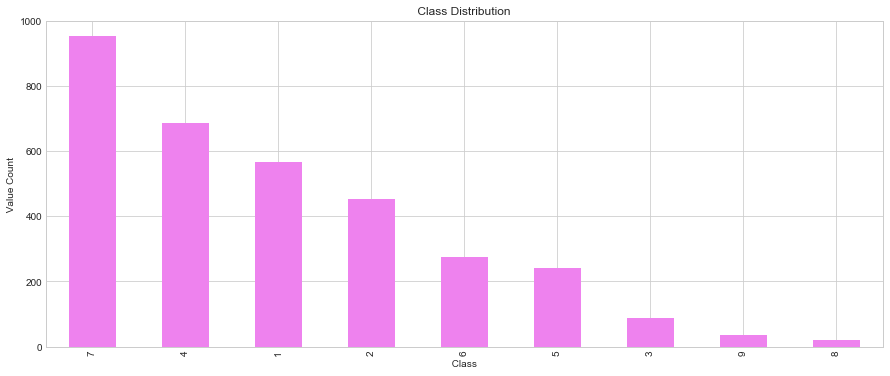

In [64]:
df.Class.value_counts().plot(kind = 'bar', figsize = (15,6), color='violet' )
plt.title(' Class Distribution ')
plt.xlabel(' Class ')
plt.ylabel(' Value Count ')
plt.show()

In [65]:
df['Class'].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

<font size = 3> Classes 9, 8 and 3 have very few number of data points such type of classes are called <b>Sparse Classes</b> 
    
Sparse Classes are those that have very few total observations. <br>
    They can be problematic for certain machine learning algorithms, causing models to be overfit.  
<br>
All the rest Classes ( i,e; 1, 2, 4, 5, 6, 7 ) have > 240 observations ( data points )  and Class 3, 9, 8 have < 90 observations

Even Class 3, 9, 8 combined have < 150 Observations

So we combine these three ( Class 3, 9, 8 ) Class to a single Class ( say we name it Class 893 ) to gain better performence from our model

And we use a seperate model later to Classify these three Classes independantly 

# Feature Engg

#  Combining Classes

In [66]:
# Sparse classes (in categorical features) are those that have very few total observations. 
#They can be problematic for certain machine learning algorithms, causing models to be overfit.

data1 =  df.copy()
data1.shape

(3321, 5)

In [67]:
newClass = []

for c in data1.Class.values:
    
    if c == 8 or c == 9 or c == 3:
        newClass.append(893)
    else:
        newClass.append(c)

In [68]:
data1['newClass'] = newClass

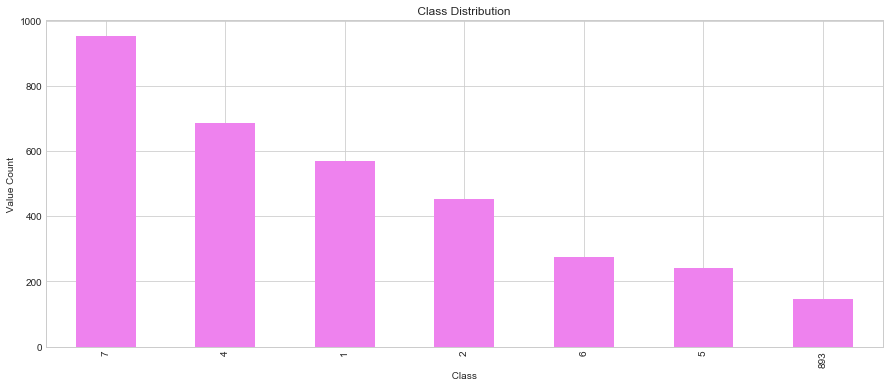

In [69]:
data1.newClass.value_counts().plot(kind = 'bar', figsize = (15,6), color='violet' )
plt.title(' Class Distribution ')
plt.xlabel(' Class ')
plt.ylabel(' Value Count ')
plt.show()

In [70]:
data1.drop( "Class", axis = 1, inplace = True )

In [71]:
data1.head(2)

,ID,Gene,Variation,TEXT,newClass
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...,1
1,1,CBL,W802*,abstract background non small cell lung cancer...,2


In [72]:
Y1 = data1['newClass']

In [73]:
# Test Train CV split

from sklearn.model_selection import train_test_split

xtrd1, xted1, ytrd1, yted1 = train_test_split( data1, Y1 , stratify = Y1, test_size = 0.2 )

xtrd1, xcvd1, ytrd1, ycvd1 = train_test_split( xtrd1, ytrd1, stratify = ytrd1, test_size = 0.2 )

In [74]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier

### Creating Data Matrix TFIDF features

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Genes
gTfVect1 = TfidfVectorizer( max_features = 1000 )

xtrGeneTF1 = gTfVect1.fit_transform( xtrd1['Gene'] )
xteGeneTF1 = gTfVect1.transform( xted1['Gene'] )
xcvGeneTF1 = gTfVect1.transform( xcvd1['Gene'] )

print(xtrGeneTF1.shape )
print(xcvGeneTF1.shape )
print(xteGeneTF1.shape )

#variation
vTfVect1 = TfidfVectorizer( max_features = 1000 )

xtrVarTF1 = vTfVect1.fit_transform( xtrd1['Variation'] )
xteVarTF1 = vTfVect1.transform( xted1['Variation'] )
xcvVarTF1 = vTfVect1.transform( xcvd1['Variation'] )

print(xtrGeneTF1.shape )
print(xcvGeneTF1.shape )
print(xteGeneTF1.shape )

# Text
teTfvect1 = TfidfVectorizer( max_features = 1000 )

xtrTextTF1 = teTfvect1.fit_transform( xtrd1['TEXT'] )

xtrTextTF1 = normalize( xtrTextTF1 , axis=0 )
# Don't forget to normalize every feature

xteTextTF1 = teTfvect1.fit_transform( xted1['TEXT'] )
  # we use the same vectorizer that was trained on train data
xteTextTF1 = normalize( xteTextTF1, axis=0 )

xcvTextTF1 = teTfvect1.fit_transform( xcvd1['TEXT'] )
xcvTextTF1 = normalize( xcvTextTF1, axis=0 ) # don't forget to normalize every feature

print( xtrTextTF1.shape )
print( xcvTextTF1.shape )
print( xteTextTF1.shape )

(2124, 226)
(532, 226)
(665, 226)
(2124, 226)
(532, 226)
(665, 226)
(2124, 1000)
(532, 1000)
(665, 1000)


In [76]:
from scipy.sparse import hstack

xtr2 = hstack(( xtrGeneTF1, xtrVarTF1, xtrTextTF1 )).tocsr()
xte2 = hstack(( xteGeneTF1, xteVarTF1, xteTextTF1 )).tocsr()
xcv2 = hstack(( xcvGeneTF1, xcvVarTF1, xcvTextTF1 )).tocsr()

print( xtr2.shape )
print( xte2.shape )
print( xcv2.shape )

(2124, 2226)
(665, 2226)
(532, 2226)


In [77]:
import warnings

warnings.filterwarnings("ignore")

## Logistic Regression TFIDF

In [90]:
alpha = [ 10 ** x for x in range(-6, 3) ]

logError = [ ]

for i in alpha :
    classifier = SGDClassifier(class_weight='balanced', alpha = i, penalty='l2', loss='log', random_state=42)
    classifier.fit(xtr2, ytrd1)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtr2, ytrd1)
    
    predictY = clf.predict_proba( xcv2 )
    
    logError.append( log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of alpha = ', i, " the log loss is : ",log_loss(ycvd1, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  1e-06  the log loss is :  1.4687972991248666
For values of alpha =  1e-05  the log loss is :  1.4566365751620225
For values of alpha =  0.0001  the log loss is :  1.2799290960834055
For values of alpha =  0.001  the log loss is :  1.2299620715710688
For values of alpha =  0.01  the log loss is :  1.3477191301676261
For values of alpha =  0.1  the log loss is :  1.6002053472026894
For values of alpha =  1  the log loss is :  1.7184310549069408
For values of alpha =  10  the log loss is :  1.730941204513949
For values of alpha =  100  the log loss is :  1.7322881002777852


In [94]:
import numpy as np 
bestA = alpha[ np.argmin(logError) ]

clf = SGDClassifier(class_weight='balanced', alpha = bestA, penalty='l2', loss='log', random_state=42)
clf.fit(xtr2, ytrd1)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtr2, ytrd1)

print(' Best alpha : ', bestA)

predictY = clf.predict_proba( xtr2 )
print(' The train log loss is : ',log_loss( ytrd1, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xte2 )
print(' The test log loss is : ',log_loss( yted1, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcv2 )
print(' The cv log loss is : ',log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )

 Best alpha :  0.001
 The train log loss is :  0.7567304666109059
 The test log loss is :  1.0972456188008082
 The cv log loss is :  1.2299620715710688


In [95]:
y_ = clf.predict( xte2 )
i =  y_ ^ yted1
print(' % of points correctly classified : ', ( ( i.shape[0] - np.count_nonzero( i ) )  / i.shape[0] ) * 100 )

 % of points correctly classified :  61.65413533834586


## Linear SVM TFIDF

In [97]:
alpha = [ 10 ** x for x in range(-6, 3) ]

logError = [ ]

for i in alpha :
    classifier = SGDClassifier( alpha = i, penalty='l2', loss='hinge', random_state=42)
    classifier.fit(xtr2, ytrd1)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtr2, ytrd1)
    
    predictY = clf.predict_proba( xcv2 )
    
    logError.append( log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of alpha = ', i, " the log loss is : ",log_loss(ycvd1, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  1e-06  the log loss is :  1.458320838533109
For values of alpha =  1e-05  the log loss is :  1.4671068426549754
For values of alpha =  0.0001  the log loss is :  1.3787852521888202
For values of alpha =  0.001  the log loss is :  1.3285852523862536
For values of alpha =  0.01  the log loss is :  1.5195654038072075
For values of alpha =  0.1  the log loss is :  1.6202019276963164
For values of alpha =  1  the log loss is :  1.6839625575676258
For values of alpha =  10  the log loss is :  1.683962565155213
For values of alpha =  100  the log loss is :  1.6839626214672128


In [101]:
import numpy as np 
bestA = alpha[ np.argmin(logError) ]

clf = SGDClassifier( alpha = bestA, penalty='l2', loss='hinge', random_state=42)
clf.fit(xtr2, ytrd1)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtr2, ytrd1)

print(' Best alpha : ', bestA)

predictY = clf.predict_proba( xtr2 )
print(' The train log loss is : ',log_loss( ytrd1, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xte2 )
print(' The test log loss is : ',log_loss( yted1, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcv2 )
print(' The cv log loss is : ',log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )

 Best alpha :  0.001
 The train log loss is :  0.7231530990540695
 The test log loss is :  1.1877776963799551
 The cv log loss is :  1.3285852523862536


In [102]:
y_ = clf.predict( xte2 )
i =  y_ ^ yted1
print(' % of points correctly classified : ', ( ( i.shape[0] - np.count_nonzero( i ) )  / i.shape[0] ) * 100 )

 % of points correctly classified :  61.65413533834586


## KNN TF IDF

In [133]:
from sklearn.neighbors import KNeighborsClassifier

k = [ 3, 5, 6, 7, 8, 10, 15, 19, 21, 25, 31, 41, 51, 61, 81, 91] # Various value of Hyperparameter

logError = [ ]

for i in k :
    classifier = KNeighborsClassifier( n_neighbors = i ) 
    classifier.fit(xtr2, ytrd1)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtr2, ytrd1)
    
    predictY = clf.predict_proba( xcv2 )
    
    logError.append( log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of K = ', i, " the log loss is : ",log_loss(ycvd1, predictY, labels=clf.classes_, eps=1e-15) )

For values of K =  3  the log loss is :  1.309102314493684
For values of K =  5  the log loss is :  1.2661574452774875
For values of K =  6  the log loss is :  1.2574809203324075
For values of K =  7  the log loss is :  1.2606531237743746
For values of K =  8  the log loss is :  1.2638659913118246
For values of K =  10  the log loss is :  1.2746841007536194
For values of K =  15  the log loss is :  1.2808868245192049
For values of K =  19  the log loss is :  1.2935249919765313
For values of K =  21  the log loss is :  1.2928428777610008
For values of K =  25  the log loss is :  1.2961464790722281
For values of K =  31  the log loss is :  1.306381082212762
For values of K =  41  the log loss is :  1.3264890372316778
For values of K =  51  the log loss is :  1.3425767099519093
For values of K =  61  the log loss is :  1.3504130998505512
For values of K =  81  the log loss is :  1.3695687972941895
For values of K =  91  the log loss is :  1.3793026850131156


### Function for Response Coding of Categorical Features

In [82]:
def feaDic( alpha, feature, df ):
    
    count = xtrd1[ feature ].value_counts()
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86.....
    
    # featDict : Feature Dict, which contains the probability array for each gene/variation
    featDict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    
    for i, denominator in count.items():
        
        # vec will contain ( P( yi == 1 / Gi ) probability of gene/variation belongs to particular class
        # vec is 9 diamensional vector
        vec = []
        
        c = [1,2,4,5,6,7,893]
        
        for j in c:
           
            # print( xtr.loc[ ( xtr['Class'] == 1 ) & ( xtr['Gene'] == 'BRCA1' )] )
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1....
            
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = xtrd1.loc[ ( xtrd1['newClass'] == j ) & ( xtrd1[feature] == i ) ]
            
            # cls_cnt.shape[0] will contain the number of time that particular feature occured in the whole data
            
            vec.append( ( cls_cnt.shape[0] + alpha * 10 ) / ( denominator + 90 * alpha ) )

        # we are adding the gene/variation to the dict as key and vec as value
        featDict[i] = vec
    return featDict

# when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
# (numerator + 10 *alpha) / (denominator + 90 *alpha ) 

In [83]:
 

def feature( alpha, feature, df ):
   
    featureDict = feaDic( alpha, feature, df )

    count = xtrd1[feature].value_counts()
    
    # feat : Gene_variation feature, it will contain the feature for each feature value in the data
    feat = []
    
    # for every feature values in the given data frame we will check if it is there in the train data then we will add...
    #... the feature to gv_fea. if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    
    for index, row in df.iterrows():
        
        if row[feature] in dict( count ).keys():
            feat.append( featureDict[ row[feature] ] )
        else:
            feat.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9])

    return feat


In [84]:
# Response-coding of the Gene feature
alpha = 1 # alpha is used for laplace smoothing

xtrGeneRC = np.array( feature( alpha, "Gene", xtrd1) )
xteGeneRC = np.array( feature( alpha, "Gene", xted1) )
xcvGeneRC = np.array( feature( alpha, "Gene", xcvd1) )

print(xtrGeneRC.shape )
print(xcvGeneRC.shape )
print(xteGeneRC.shape )


(2124, 7)
(532, 7)
(665, 7)


In [85]:
# Response-coding of the Variation feature
alpha = 1 # alpha is used for laplace smoothing

xtrVarRC = np.array( feature( alpha, "Variation", xtrd1) )
xteVarRC = np.array( feature( alpha, "Variation", xted1) )
xcvVarRC = np.array( feature( alpha, "Variation", xcvd1) )

print(xtrVarRC.shape )
print(xcvVarRC.shape )
print(xteVarRC.shape )

(2124, 7)
(532, 7)
(665, 7)


In [105]:
from sklearn.preprocessing import normalize

from collections import Counter, defaultdict

In [106]:
# cls_text is a data frame
# 1. for every row in data fram consider the 'TEXT'
# 2.     Split the words by space
# 3.     Make a dict with those words
# 4.     Increment its count whenever we see that word

def extract(classText):
    
    dictionary = defaultdict( int )
    
    for index, row in classText.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [107]:
import math
def textResponseC(df):
    
    textFeat = np.zeros( ( df.shape[0], 7 ) )
    
    #c = [1,2,4,5,6,7,893]

    for i in range(0,7):
        row_index = 0
        
        for index, row in df.iterrows():
            
            prob = 0
            for word in row['TEXT'].split():
                prob += math.log(( ( dictli[i].get( word, 0 ) + 10 ) / ( totaldict.get( word, 0 ) + 90 ) ))
                # here 10 and 90 are alpha fro Laplace smoothing 
            
            textFeat[ row_index ][i] = math.exp( prob / len( row['TEXT'].split() ))
            row_index += 1
        
    return textFeat

# Ref : #https://stackoverflow.com/a/1602964

In [108]:
dictli = [] # dictli : contains 9 dictoinaries each corresponds to a class

c = [1,2,4,5,6,7,893]

for i in c:
    classText = xtrd1[ xtrd1['newClass'] == i ]  # build a word dict based on the words in that class
    dictli.append( extract( classText ) ) # append it to dictli

# dictli[i] is build on i'th  class text data

totaldict = extract( xtrd1 ) # totaldict is buid on whole training text data

In [109]:
totaldict = extract( xtrd1 ) # totaldict is buid on whole training text data
# Response coding of text features

xtrTextRC  = textResponseC( xtrd1 )
xteTextRC  = textResponseC( xted1 )
xcvTextRC  = textResponseC( xcvd1 )

print( xtrTextRC.shape ) 
print( xteTextRC.shape ) 
print( xcvTextRC.shape ) 

(2124, 7)
(665, 7)
(532, 7)


In [110]:
# We convert each row values such that they sum to 1  

xtrTextRC = ( xtrTextRC.T / xtrTextRC.sum( axis=1 ) ).T
xteTextRC = ( xteTextRC.T / xteTextRC.sum( axis=1 ) ).T
xcvTextRC = ( xcvTextRC.T / xcvTextRC.sum( axis=1 ) ).T

# Ref : # https://stackoverflow.com/a/16202486

In [111]:

xtrRC = np.hstack(( xtrGeneRC, xtrVarRC, xtrTextRC )) # giving error on just hstack() and not on np.hstack()
xteRC = np.hstack(( xteGeneRC, xteVarRC, xteTextRC ))
xcvRC = np.hstack(( xcvGeneRC, xcvVarRC, xcvTextRC ))  

print( xtrRC.shape )
print( xteRC.shape )
print( xcvRC.shape )

(2124, 21)
(665, 21)
(532, 21)


## Logistic Regression Response Coding

In [134]:
alpha = [ 10 ** x for x in range(-6, 3) ]

logError = [ ]

for i in alpha :
    classifier = SGDClassifier(class_weight='balanced', alpha = i, penalty='l2', loss='log', random_state=42)
    classifier.fit(xtrRC, ytrd1)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtrRC, ytrd1)
    
    predictY = clf.predict_proba( xcvRC )
    
    logError.append( log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of alpha = ', i, " the log loss is : ",log_loss(ycvd1, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  1e-06  the log loss is :  1.2097329767518612
For values of alpha =  1e-05  the log loss is :  1.1991886238924199
For values of alpha =  0.0001  the log loss is :  1.1871013330642404
For values of alpha =  0.001  the log loss is :  1.2306775662446807
For values of alpha =  0.01  the log loss is :  1.2716702604378192
For values of alpha =  0.1  the log loss is :  1.2833499267625812
For values of alpha =  1  the log loss is :  1.2988574185974213
For values of alpha =  10  the log loss is :  1.4329001028086221
For values of alpha =  100  the log loss is :  1.4882458591820107


In [149]:
import numpy as np 
bestA = alpha[ np.argmin(logError) ]

clf = SGDClassifier(class_weight='balanced', alpha = bestA, penalty='l2', loss='log', random_state=42)
clf.fit(xtrRC, ytrd1)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtrRC, ytrd1)

print(' Best alpha : ', bestA)

predictY = clf.predict_proba( xtrRC )
print(' The train log loss is : ',log_loss( ytrd1, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xteRC )
print(' The test log loss is : ',log_loss( yted1, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcvRC )
print(' The cv log loss is : ',log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )

 Best alpha :  0.0001
 The train log loss is :  0.847346054797082
 The test log loss is :  1.0578775240871088
 The cv log loss is :  1.1871013330642404


## KNN  Response Coding

In [112]:
from sklearn.neighbors import KNeighborsClassifier

k = [ 3, 5, 6, 7, 8, 10, 15, 19, 21, 25, 31, 41, 51, 61, 81, 91] # Various value of Hyperparameter

logError = [ ]

for i in k :
    classifier = KNeighborsClassifier( n_neighbors = i ) 
    classifier.fit(xtrRC, ytrd1)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtrRC, ytrd1)
    
    predictY = clf.predict_proba( xcvRC )
    
    logError.append( log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of K = ', i, " the log loss is : ",log_loss(ycvd1, predictY, labels=clf.classes_, eps=1e-15) )

For values of K =  3  the log loss is :  1.1496646063660707
For values of K =  5  the log loss is :  1.1271072704794478
For values of K =  6  the log loss is :  1.124875237202507
For values of K =  7  the log loss is :  1.1298541755794924
For values of K =  8  the log loss is :  1.1228641944883615
For values of K =  10  the log loss is :  1.1318325684713941
For values of K =  15  the log loss is :  1.1561685601388505
For values of K =  19  the log loss is :  1.170575958728822
For values of K =  21  the log loss is :  1.1782535432088335
For values of K =  25  the log loss is :  1.1839933122361526
For values of K =  31  the log loss is :  1.195787700430199
For values of K =  41  the log loss is :  1.206799952666955
For values of K =  51  the log loss is :  1.2117733390622996
For values of K =  61  the log loss is :  1.2167668204386415
For values of K =  81  the log loss is :  1.2332846602789427
For values of K =  91  the log loss is :  1.224721744635219


In [113]:
bestk = k[np.argmin( logError )]

clf = KNeighborsClassifier( n_neighbors = bestk )
clf.fit(xtrRC, ytrd1)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtrRC, ytrd1)

print(' Best K : ', bestk)

predictY = clf.predict_proba( xtrRC )
print(' The train log loss is : ',log_loss( ytrd1, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xteRC )
print(' The test log loss is : ',log_loss( yted1, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcvRC )
print(' The cv log loss is : ',log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )

 Best K :  8
 The train log loss is :  0.5460165182858353
 The test log loss is :  1.0314135355026817
 The cv log loss is :  1.1228641944883615


In [114]:
y_ = clf.predict( xcvRC )
i =  y_ ^ ycvd1
print(' % of points correctly classified : ', ( ( i.shape[0] - np.count_nonzero( i ) )  / i.shape[0] ) * 100 )

 % of points correctly classified :  60.902255639097746


# Random Forest

### Response Coding

In [53]:
from sklearn.ensemble import RandomForestClassifier

alpha = [100,200,300, 500,1000] # Various value of Hyperparameter
max_depth = [2, 5, 7, 10]

logError = [ ]

for i in alpha :
    for j in max_depth:
        classifier = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        classifier.fit(xtrRC, ytrd1)

        # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
        # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
        # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction

        clf = CalibratedClassifierCV( classifier, method="sigmoid" )

        # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
        # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.

        clf.fit(xtrRC, ytrd1)

        predictY = clf.predict_proba( xcvRC )

        logError.append( log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )
        print('For values of alpha = ', i,' and depth = ', j, " the log loss is : ",log_loss(ycvd1, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  100  and depth =  2  the log loss is :  1.8135106327650334
For values of alpha =  100  and depth =  5  the log loss is :  1.4653435642351722
For values of alpha =  100  and depth =  7  the log loss is :  1.5518833462740955
For values of alpha =  100  and depth =  10  the log loss is :  1.8170193084122674
For values of alpha =  200  and depth =  2  the log loss is :  1.8584374638726346
For values of alpha =  200  and depth =  5  the log loss is :  1.3582053710797792
For values of alpha =  200  and depth =  7  the log loss is :  1.4448862491701397
For values of alpha =  200  and depth =  10  the log loss is :  1.7739596446510717
For values of alpha =  300  and depth =  2  the log loss is :  1.6753668927828127
For values of alpha =  300  and depth =  5  the log loss is :  1.3287588166618869
For values of alpha =  300  and depth =  7  the log loss is :  1.416561059059895
For values of alpha =  300  and depth =  10  the log loss is :  1.7484154939873404
For values of 

### TFIDF

In [76]:
alpha = [100,200,500,1000,2000] # Various value of Hyperparameter
max_depth = [5, 10, 20]

logError = [ ]

for i in alpha :
    for j in max_depth:
        classifier = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        classifier.fit(xtr2, ytrd1)

        # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
        # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
        # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction

        clf = CalibratedClassifierCV( classifier, method="sigmoid" )

        # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
        # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.

        clf.fit(xtr2, ytrd1)

        predictY = clf.predict_proba( xcv2 )

        logError.append( log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )
        print('For values of alpha = ', i,' and depth = ', j, " the log loss is : ",log_loss(ycvd1, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  100  and depth =  5  the log loss is :  1.8286017630445017
For values of alpha =  100  and depth =  10  the log loss is :  1.8095730920310142
For values of alpha =  100  and depth =  20  the log loss is :  1.7970179946986695
For values of alpha =  200  and depth =  5  the log loss is :  1.8133310093991468
For values of alpha =  200  and depth =  10  the log loss is :  1.7959032569314377
For values of alpha =  200  and depth =  20  the log loss is :  1.7875699946931947
For values of alpha =  500  and depth =  5  the log loss is :  1.7955359030590359
For values of alpha =  500  and depth =  10  the log loss is :  1.7885713206960039
For values of alpha =  500  and depth =  20  the log loss is :  1.782934556969202
For values of alpha =  1000  and depth =  5  the log loss is :  1.7958811959984269
For values of alpha =  1000  and depth =  10  the log loss is :  1.7904618647087542
For values of alpha =  1000  and depth =  20  the log loss is :  1.7854094176380635
For va

## XG Boost Response Coding features

In [56]:
import xgboost as xgb

max_depth = [ 1, 5, 10, 50, 100, 500 ]
learning_rate = [ 0.01, 0.1, 0 , 1  ]

logError = [ ]

for i in learning_rate :
    for j in max_depth:
        
        classifier = xgb.XGBClassifier( objective = "binary:logistic", random_state = 42, max_depth = j, eta = i )
        classifier.fit(xtrRC, ytrd1)

        # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
        # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
        # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction

        clf = CalibratedClassifierCV( classifier, method="sigmoid" )

        # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
        # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.

        clf.fit(xtrRC, ytrd1)

        predictY = clf.predict_proba( xcvRC )

        logError.append( log_loss( ycvd1, predictY, labels = clf.classes_, eps = 1e-15) )
        print('For values of alpha = ', i,' and depth = ', j, " the log loss is : ",log_loss(ycvd1, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  0.01  and depth =  1  the log loss is :  3.959960525623231
For values of alpha =  0.01  and depth =  5  the log loss is :  2.540907705410178
For values of alpha =  0.01  and depth =  10  the log loss is :  2.535579048226781
For values of alpha =  0.01  and depth =  50  the log loss is :  2.535579048226781
For values of alpha =  0.01  and depth =  100  the log loss is :  2.535579048226781
For values of alpha =  0.01  and depth =  500  the log loss is :  2.535579048226781
For values of alpha =  0.1  and depth =  1  the log loss is :  3.959960525623231
For values of alpha =  0.1  and depth =  5  the log loss is :  2.540907705410178
For values of alpha =  0.1  and depth =  10  the log loss is :  2.535579048226781
For values of alpha =  0.1  and depth =  50  the log loss is :  2.535579048226781
For values of alpha =  0.1  and depth =  100  the log loss is :  2.535579048226781
For values of alpha =  0.1  and depth =  500  the log loss is :  2.535579048226781
For values

In [153]:
from prettytable import PrettyTable
    
x = PrettyTable()
   
x.field_names = [ " Model ", " Featurization ", " Train log loss ", " CV log loss ", " Test log loss " ]

x.add_row( [ " Logistic Regression ", " TFIDF ", " 0.7567 ", " 1.2299 ", " 1.0972 " ] )
x.add_row( [ " Linear SVM (balanced class) ", " TFIDF ", " 0.7231 ", " 1.3285 ", " 1.1877 " ] )
x.add_row( [ " K Nearest Neighbour ", " TFIDF ", " * ", " 1.2574 ", " * " ] )
x.add_row( [ " Random Forest ", " TFIDF ", " * ", " 1.7852 ", " * " ] )

x.add_row( [ " Logistic Regression ", " ResponseCoding ", " 0.8473 ", " 1.1871 ", " 1.0578 " ] )
x.add_row( [ " K Nearest Neighbour ", " ResponseCoding ", " 0.5460 ", " 1.1228 ", " 1.0314 " ] )
x.add_row( [ " Random Forest ", " ResponseCoding ", " * ", " 1.3279 ", " * " ] )
x.add_row( [ " XG Boost ", " ResponseCoding ", " * ", " 2.5355 ", " * " ] )


print( x )
print("\n\t\t\t * : ignored calculation since CV log loss > 1.2 ")
# Ref : http://zetcode.com/python/prettytable/

+-------------------------------+------------------+------------------+---------------+-----------------+
|             Model             |  Featurization   |  Train log loss  |  CV log loss  |  Test log loss  |
+-------------------------------+------------------+------------------+---------------+-----------------+
|      Logistic Regression      |      TFIDF       |      0.7567      |     1.2299    |      1.0972     |
|  Linear SVM (balanced class)  |      TFIDF       |      0.7231      |     1.3285    |      1.1877     |
|      K Nearest Neighbour      |      TFIDF       |        *         |     1.2574    |        *        |
|         Random Forest         |      TFIDF       |        *         |     1.7852    |        *        |
|      Logistic Regression      |  ResponseCoding  |      0.8473      |     1.1871    |      1.0578     |
|      K Nearest Neighbour      |  ResponseCoding  |      0.5460      |     1.1228    |      1.0314     |
|         Random Forest         |  ResponseCod

Since the log loss is not still not quite low ( < 1.0 ) we need to perform futher Feature Engineering <br><br>

# Creating new features + combining classes

In [13]:
data2 =  data1.copy()
data2.shape

(3321, 5)

In [14]:
data2.head(2)

,ID,Gene,Variation,TEXT,newClass
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...,1
1,1,CBL,W802*,abstract background non small cell lung cancer...,2


In [15]:
gene = dict( data2.Gene.value_counts() )
len( gene )
gene['CBL']

25

In [16]:
# Loop for calculating len of each Gene feature and no. of time it appears in the dataset

li = []
le = []
for ge in data2.Gene:
    li.append( gene[ ge ] )
    le.append( len(ge) )
data2['countGene'] = li
data2['lenGene'] = le

In [17]:
data2.head()

,ID,Gene,Variation,TEXT,newClass,countGene,lenGene
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...,1,1,6
1,1,CBL,W802*,abstract background non small cell lung cancer...,2,25,3
2,2,CBL,Q249E,abstract background non small cell lung cancer...,2,25,3
3,3,CBL,N454D,recent evidence demonstrated acquired uniparen...,893,25,3
4,4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...,4,25,3


In [18]:
var = dict( data2.Variation.value_counts() )
len(var)
var['Truncating_Mutations']

93

In [19]:
# Loop for calculating len of each Variation feature and no. of time it appears in the dataset

li = []
le = []
for v in data2.Variation:
    li.append( var[ v ] )
    le.append( len(v) )
data2['countVar'] = li
data2['lenVar'] = le

In [20]:
data2.head()

,ID,Gene,Variation,TEXT,newClass,countGene,lenGene,countVar,lenVar
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...,1,1,6,93,20
1,1,CBL,W802*,abstract background non small cell lung cancer...,2,25,3,1,5
2,2,CBL,Q249E,abstract background non small cell lung cancer...,2,25,3,1,5
3,3,CBL,N454D,recent evidence demonstrated acquired uniparen...,893,25,3,1,5
4,4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...,4,25,3,1,5


In [21]:
a = data2['TEXT']
a = list(a)
len(a)

In [23]:
from tqdm import tqdm
from statistics import mode
from collections import Counter

word = []
max = []
for sent in tqdm( a ) :
    for w in sent.split():
          word.append(w)
    mc = Counter(word)
    max.append(mc)

In [24]:
# Loop for calculating len of each TEXT features
le = []
for sent in tqdm( a ):
    le.append( len(sent) )

data2['lenText'] = le

100%|█████████████████████████████████████████████████████████████████████████| 3321/3321 [00:00<00:00, 1110788.16it/s]


In [25]:
data2.head()

,ID,Gene,Variation,TEXT,newClass,countGene,lenGene,countVar,lenVar,lenText
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...,1,1,6,93,20,30836
1,1,CBL,W802*,abstract background non small cell lung cancer...,2,25,3,1,5,27844
2,2,CBL,Q249E,abstract background non small cell lung cancer...,2,25,3,1,5,27844
3,3,CBL,N454D,recent evidence demonstrated acquired uniparen...,893,25,3,1,5,28093
4,4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...,4,25,3,1,5,31649


In [26]:
print( len( data2.lenText.value_counts() ),' Unique length of TEXT feature' )

data2.lenText.value_counts().head()

1899


32995    53
37392    47
34377    42
26199    31
27133    31
Name: lenText, dtype: int64

In [27]:
print( len( data2.lenGene.value_counts() ),' Unique length of Gene feature' )

data2.lenGene.value_counts()

7


4    1276
5    1073
6     500
3     420
7      31
2      20
8       1
Name: lenGene, dtype: int64

In [28]:
print( len( data2.lenVar.value_counts() ),' Unique length of Variance feature' )

data2.lenVar.value_counts().head()

33


5     1647
6      569
4      434
20     104
8       88
Name: lenVar, dtype: int64

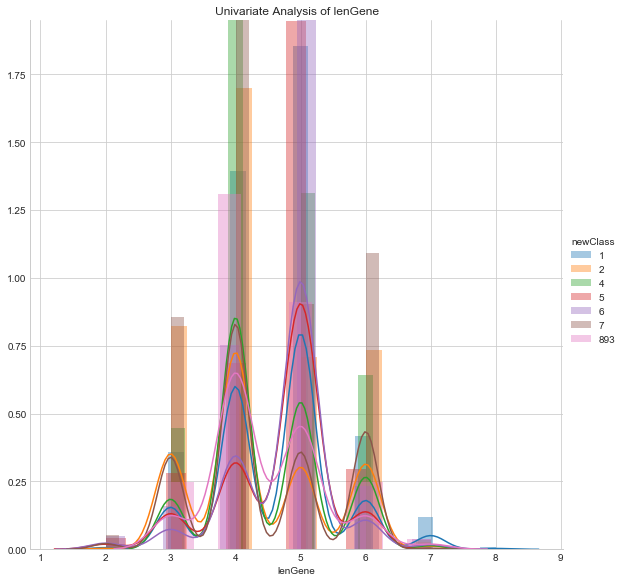

In [29]:
sns.set_style("whitegrid")
sns.FacetGrid(data2, hue='newClass', size=8).map(sns.distplot, "lenGene").add_legend()
plt.title('Univariate Analysis of lenGene')
plt.show()

In [30]:
# Loop for calculating 1st word and last word of every TEXT feature
li = []
w1 = [] # 1st word
wl = [] # last word

for sent in tqdm(a):
    for w in sent.split():
        li.append(w)
    
    w1.append( li[0] )
    wl.append( li[-1] )
    li = []

100%|█████████████████████████████████████████████████████████████████████████████| 3321/3321 [00:03<00:00, 918.58it/s]


In [31]:
data2['text1st'] = w1

In [32]:
data2['textLast'] = wl

In [33]:
data2.head()

,ID,Gene,Variation,TEXT,newClass,countGene,lenGene,countVar,lenVar,lenText,text1st,textLast
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...,1,1,6,93,20,30836,cyclin,females
1,1,CBL,W802*,abstract background non small cell lung cancer...,2,25,3,1,5,27844,abstract,tumorigenesis
2,2,CBL,Q249E,abstract background non small cell lung cancer...,2,25,3,1,5,27844,abstract,tumorigenesis
3,3,CBL,N454D,recent evidence demonstrated acquired uniparen...,893,25,3,1,5,28093,recent,attractive
4,4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...,4,25,3,1,5,31649,oncogenic,cancer


Features Created :<br>
    <b>countGene</b> : No. of times that Gene occour in the dataset <br>
    <b>lenGene</b> : Length of that Gene<br>
    <b>countVar</b> : No. of times that Variation occour in the dataset <br>
    <b>lenVar</b> : Length of that Variation<br>
    <b>text1st</b> : First word in the feature TEXT<br>
    <b>textLast</b> :  Last word in the feature TEXT<br>
    <b>lenText</b>  : Length of the text ( no. of words present ) <br>

In [34]:
print( len( data2.text1st.value_counts() ) )
data2.text1st.value_counts().head()

596


abstract        311
mutations       123
introduction    113
purpose          84
tumor            74
Name: text1st, dtype: int64

In [35]:
print( len( data2.textLast.value_counts() ) )

data2.textLast.value_counts().head()

714


cancer        98
mutations     92
brca1         80
patients      69
inhibitors    65
Name: textLast, dtype: int64

In [36]:
Y2 = data2['newClass']

### Test Train CV split and Creating Data Matrix

In [46]:
# Test Train CV split

from sklearn.model_selection import train_test_split

xtrd2, xted2, ytrd2, yted2 = train_test_split( data2, Y2 , stratify = Y2, test_size = 0.2 )

xtrd2, xcvd2, ytrd2, ycvd2 = train_test_split( xtrd2, ytrd2, stratify = ytrd2, test_size = 0.2 )

##  for TF IDF features

In [47]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

#Genes
gTfVect2 = TfidfVectorizer( max_features = 1000 )

xtrGeneTF2 = gTfVect2.fit_transform( xtrd2['Gene'] )
xteGeneTF2 = gTfVect2.transform( xted2['Gene'] )
xcvGeneTF2 = gTfVect2.transform( xcvd2['Gene'] )

print(xtrGeneTF2.shape )
print(xcvGeneTF2.shape )
print(xteGeneTF2.shape )

#variation
vTfVect2 = TfidfVectorizer( max_features = 1000 )

xtrVarTF2 = vTfVect2.fit_transform( xtrd2['Variation'] )
xteVarTF2 = vTfVect2.transform( xted2['Variation'] )
xcvVarTF2 = vTfVect2.transform( xcvd2['Variation'] )

print(xtrGeneTF2.shape )
print(xcvGeneTF2.shape )
print(xteGeneTF2.shape )

# Text
teTfvect2 = TfidfVectorizer( max_features = 1000 )

xtrTextTF2 = teTfvect2.fit_transform( xtrd2['TEXT'] )
xtrTextTF2 = normalize( xtrTextTF2 , axis=0 ) # Don't forget to normalize every feature

xteTextTF2 = teTfvect2.transform( xted2['TEXT'] )
xteTextTF2 = normalize( xteTextTF2, axis=0 )

xcvTextTF2 = teTfvect2.transform( xcvd2['TEXT'] )
xcvTextTF2 = normalize( xcvTextTF2, axis=0 ) 

print( xtrTextTF2.shape )
print( xcvTextTF2.shape )
print( xteTextTF2.shape )


# First word in Text
t1stTfVect2 = TfidfVectorizer( max_features = 1000 )

xtrT1stTF2 = t1stTfVect2.fit_transform( xtrd2['text1st'] )
xteT1stTF2 = t1stTfVect2.transform( xted2['text1st'] )
xcvT1stTF2 = t1stTfVect2.transform( xcvd2['text1st'] )

print(xtrT1stTF2.shape )
print(xteT1stTF2.shape )
print(xcvT1stTF2.shape )


# Last word in Text
tLTfVect2 = TfidfVectorizer( max_features = 1000 )

xtrTLTF2 = tLTfVect2.fit_transform( xtrd2['textLast'] )
xteTLTF2 = tLTfVect2.transform( xted2['textLast'] )
xcvTLTF2 = tLTfVect2.transform( xcvd2['textLast'] )

print(xtrTLTF2.shape )
print(xteTLTF2.shape )
print(xcvTLTF2.shape )

(2124, 237)
(532, 237)
(665, 237)
(2124, 237)
(532, 237)
(665, 237)
(2124, 1000)
(532, 1000)
(665, 1000)
(2124, 472)
(665, 472)
(532, 472)
(2124, 561)
(665, 561)
(532, 561)


In [48]:
from sklearn.preprocessing import Normalizer

# countGene
norm = Normalizer()

xtrCG = norm.fit_transform( xtrd2['countGene'].values.reshape(-1,1) )
xcvCG = norm.transform( xcvd2['countGene'].values.reshape(-1,1) )
xteCG = norm.transform( xted2['countGene'].values.reshape(-1,1) )
print(xtrCG.shape)
print(xteCG.shape)
print(xcvCG.shape)


# countVar
norm = Normalizer()

xtrCV = norm.fit_transform( xtrd2['countVar'].values.reshape(-1,1) )
xcvCV = norm.transform( xcvd2['countVar'].values.reshape(-1,1) )
xteCV = norm.transform( xted2['countVar'].values.reshape(-1,1) )
print(xtrCV.shape)
print(xteCV.shape)
print(xcvCV.shape)


# lenVar
norm = Normalizer()

xtrLV = norm.fit_transform( xtrd2['lenVar'].values.reshape(-1,1) )
xcvLV = norm.transform( xcvd2['lenVar'].values.reshape(-1,1) )
xteLV = norm.transform( xted2['lenVar'].values.reshape(-1,1) )
print(xtrLV.shape)
print(xteLV.shape)
print(xcvLV.shape)


#lenGene
norm = Normalizer()

xtrLG = norm.fit_transform( xtrd2['lenGene'].values.reshape(-1,1) )
xcvLG = norm.transform( xcvd2['lenGene'].values.reshape(-1,1) )
xteLG = norm.transform( xted2['lenGene'].values.reshape(-1,1) )
print(xtrLG.shape)
print(xteLG.shape)
print(xcvLG.shape)


#lenText
norm = Normalizer()

xtrLT = norm.fit_transform( xtrd2['lenText'].values.reshape(-1,1) )
xcvLT = norm.transform( xcvd2['lenText'].values.reshape(-1,1) )
xteLT = norm.transform( xted2['lenText'].values.reshape(-1,1) )
print(xtrLT.shape)
print(xteLT.shape)
print(xcvLT.shape)

(2124, 1)
(665, 1)
(532, 1)
(2124, 1)
(665, 1)
(532, 1)
(2124, 1)
(665, 1)
(532, 1)
(2124, 1)
(665, 1)
(532, 1)
(2124, 1)
(665, 1)
(532, 1)


In [49]:
from scipy.sparse import hstack

xtr3 = hstack(( xtrGeneTF2, xtrVarTF2, xtrTextTF2, xtrT1stTF2, xtrTLTF2, xtrCG, xtrCV, xtrLV, xtrLG, xtrLT )).tocsr()
xte3 = hstack(( xteGeneTF2, xteVarTF2, xteTextTF2, xteT1stTF2, xteTLTF2, xteCG, xteCV, xteLV, xteLG, xteLT )).tocsr()
xcv3 = hstack(( xcvGeneTF2, xcvVarTF2, xcvTextTF2, xcvT1stTF2, xcvTLTF2, xcvCG, xcvCV, xcvLV, xcvLG, xcvLT )).tocsr()

print( xtr3.shape )
print( xte3.shape )
print( xcv3.shape )

(2124, 3275)
(665, 3275)
(532, 3275)


In [50]:
import warnings  # removes warning messages from the output

warnings.filterwarnings("ignore")

## Logistic Regression

In [51]:
alpha = [ 10 ** x for x in range(-6, 3) ]

logError = [ ]

for i in alpha :
    classifier = SGDClassifier( alpha = i, penalty='l2', loss='log', random_state = 42 )
    classifier.fit(xtr3, ytrd2)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtr3, ytrd2)
    
    predictY = clf.predict_proba( xcv3 )
    
    logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of alpha = ', i, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  1e-06  the log loss is :  0.9862240536254596
For values of alpha =  1e-05  the log loss is :  0.9892814497430283
For values of alpha =  0.0001  the log loss is :  0.9768187905561545
For values of alpha =  0.001  the log loss is :  0.9783214768246432
For values of alpha =  0.01  the log loss is :  1.0876345920493318
For values of alpha =  0.1  the log loss is :  1.1901507106049096
For values of alpha =  1  the log loss is :  1.330142396876936
For values of alpha =  10  the log loss is :  1.539050725671884
For values of alpha =  100  the log loss is :  1.5957789173148795


In [52]:
import numpy as np 
bestA = alpha[ np.argmin(logError) ]
clf = SGDClassifier( alpha = bestA, penalty='l2', loss='log', random_state=42)
clf.fit(xtr3, ytrd2)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtr3, ytrd2)

print(' Best alpha : ', bestA)

predictY = clf.predict_proba( xtr3 )
print(' The train log loss is : ',log_loss( ytrd2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xte3 )
print(' The test log loss is : ',log_loss( yted2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcv3 )
print(' The cv log loss is : ',log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )

 Best alpha :  0.0001
 The train log loss is :  0.5302739124807866
 The test log loss is :  0.9257778414597118
 The cv log loss is :  0.9768187905561545


In [55]:
y_ = clf.predict( xte3 )
i =  y_ ^ yted2
print(' % of points correctly classified : ', ( ( i.shape[0] - np.count_nonzero( i ) )  / i.shape[0] ) * 100 )

print(' % of points missclassified  : ', ( np.count_nonzero(( clf.predict( xte3 )- yted2 )) / yted2.shape[0] )* 100 )

 % of points correctly classified :  66.9172932330827


## Linear SVM

In [117]:
alpha = [ 10 ** x for x in range(-6, 3) ]

logError = [ ]

for i in alpha :
    classifier = SGDClassifier(class_weight = 'balanced', alpha = i, penalty='l2', loss='hinge', random_state = 42 )
    classifier.fit(xtr3, ytrd2)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtr3, ytrd2)
    
    predictY = clf.predict_proba( xcv3 )
    
    logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of alpha = ', i, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  1e-06  the log loss is :  0.9872505633126057
For values of alpha =  1e-05  the log loss is :  0.9993229913796619
For values of alpha =  0.0001  the log loss is :  0.9945911488138485
For values of alpha =  0.001  the log loss is :  0.9921881085261784
For values of alpha =  0.01  the log loss is :  1.0648666101555004
For values of alpha =  0.1  the log loss is :  1.120345617768938
For values of alpha =  1  the log loss is :  1.330472839940044
For values of alpha =  10  the log loss is :  1.5935044871200792
For values of alpha =  100  the log loss is :  1.593501431762243


In [118]:
import numpy as np 
bestA = alpha[ np.argmin(logError) ]
clf = SGDClassifier(class_weight = 'balanced', alpha = bestA, penalty='l2', loss='log', random_state=42)
clf.fit(xtr3, ytrd2)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtr3, ytrd2)

print(' Best alpha : ', bestA)

predictY = clf.predict_proba( xtr3 )
print(' The train log loss is : ',log_loss( ytrd2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xte3 )
print(' The test log loss is : ',log_loss( yted2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcv3 )
print(' The cv log loss is : ',log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )

 Best alpha :  1e-06
 The train log loss is :  0.576004951297067
 The test log loss is :  0.9432775710318827
 The cv log loss is :  0.9946360345459967


In [119]:
y_ = clf.predict( xte3 )
i =  y_ ^ yted2
print(' % of points correctly classified : ', ( ( i.shape[0] - np.count_nonzero( i ) )  / i.shape[0] ) * 100 )

print(' % of points missclassified  : ', ( np.count_nonzero(( clf.predict( xte3 )- yted2 )) / yted2.shape[0] )* 100 )

 % of points correctly classified :  68.1203007518797
 % of points missclassified  :  31.879699248120303


## Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier

alpha = [100,200,500,1000,2000] # Various value of Hyperparameter
max_depth = [5, 10, 20]

logError = [ ]

for i in alpha :
    for j in max_depth:
        classifier = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        classifier.fit(xtr3, ytrd2)

        # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
        # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
        # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction

        clf = CalibratedClassifierCV( classifier, method="sigmoid" )

        # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
        # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.

        clf.fit(xtr3, ytrd2)

        predictY = clf.predict_proba( xcv3 )

        logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
        print('For values of alpha = ', i,' and depth = ', j, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  100  and depth =  5  the log loss is :  1.2046900080062566
For values of alpha =  100  and depth =  10  the log loss is :  1.2339441021729443
For values of alpha =  100  and depth =  20  the log loss is :  1.304013707971388
For values of alpha =  200  and depth =  5  the log loss is :  1.1993286315154505
For values of alpha =  200  and depth =  10  the log loss is :  1.2193528263625544
For values of alpha =  200  and depth =  20  the log loss is :  1.2896243262020486
For values of alpha =  500  and depth =  5  the log loss is :  1.1943661211214818
For values of alpha =  500  and depth =  10  the log loss is :  1.2168962762804376
For values of alpha =  500  and depth =  20  the log loss is :  1.284611574583206
For values of alpha =  1000  and depth =  5  the log loss is :  1.1916428318879262
For values of alpha =  1000  and depth =  10  the log loss is :  1.2146662457010344
For values of alpha =  1000  and depth =  20  the log loss is :  1.286113900207443
For valu

## for Response Coding

In [130]:
def feaDic( alpha, feature, df ):
    
    count = xtrd2[ feature ].value_counts()
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86.....
    
    # featDict : Feature Dict, which contains the probability array for each gene/variation
    featDict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    
    for i, denominator in count.items():
        
        # vec will contain ( P( yi == 1 / Gi ) probability of gene/variation belongs to particular class
        # vec is 9 diamensional vector
        vec = []
        
        c = [1,2,4,5,6,7,893]
        
        for j in c:
           
            # print( xtr.loc[ ( xtr['Class'] == 1 ) & ( xtr['Gene'] == 'BRCA1' )] )
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1....
            
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = xtrd2.loc[ ( xtrd2['newClass'] == j ) & ( xtrd2[feature] == i ) ]
            
            # cls_cnt.shape[0] will contain the number of time that particular feature occured in the whole data
            
            vec.append( ( cls_cnt.shape[0] + alpha * 10 ) / ( denominator + 90 * alpha ) )

        # we are adding the gene/variation to the dict as key and vec as value
        featDict[i] = vec
    return featDict

# when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
# (numerator + 10 *alpha) / (denominator + 90 *alpha ) 

def feature( alpha, feature, df ):
   
    featureDict = feaDic( alpha, feature, df )

    count = xtrd2[feature].value_counts()
    
    # feat : Gene_variation feature, it will contain the feature for each feature value in the data
    feat = []
    
    # for every feature values in the given data frame we will check if it is there in the train data then we will add...
    #... the feature to gv_fea. if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    
    for index, row in df.iterrows():
        
        if row[feature] in dict( count ).keys():
            feat.append( featureDict[ row[feature] ] )
        else:
            feat.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9])

    return feat


In [131]:
# Response-coding of the Gene feature
alpha = 1 # alpha is used for laplace smoothing

xtrGeneRC1 = np.array( feature( alpha, "Gene", xtrd2) )
xteGeneRC1 = np.array( feature( alpha, "Gene", xted2) )
xcvGeneRC1 = np.array( feature( alpha, "Gene", xcvd2) )

print(xtrGeneRC1.shape )
print(xcvGeneRC1.shape )
print(xteGeneRC1.shape )


# Response-coding of the Variation feature
alpha = 1 # alpha is used for laplace smoothing

xtrVarRC1 = np.array( feature( alpha, "Variation", xtrd2) )
xteVarRC1 = np.array( feature( alpha, "Variation", xted2) )
xcvVarRC1 = np.array( feature( alpha, "Variation", xcvd2) )

print(xtrVarRC1.shape )
print(xcvVarRC1.shape )
print(xteVarRC1.shape )


xtrT1stRC = np.array( feature( alpha, "text1st", xtrd2) )
xteT1stRC = np.array( feature( alpha, "text1st", xted2) )
xcvT1stRC = np.array( feature( alpha, "text1st", xcvd2) )

print(xtrT1stRC.shape )
print(xteT1stRC.shape )
print(xcvT1stRC.shape )


xtrTLRC = np.array( feature( alpha, "textLast", xtrd2) )
xteTLRC = np.array( feature( alpha, "textLast", xted2) )
xcvTLRC = np.array( feature( alpha, "textLast", xcvd2) )

print(xtrTLRC.shape )
print(xteTLRC.shape )
print(xcvTLRC.shape )


(2124, 7)
(532, 7)
(665, 7)
(2124, 7)
(532, 7)
(665, 7)
(2124, 7)
(665, 7)
(532, 7)
(2124, 7)
(665, 7)
(532, 7)


In [133]:
from sklearn.preprocessing import normalize

from collections import Counter, defaultdict
# cls_text is a data frame
# 1. for every row in data fram consider the 'TEXT'
# 2.     Split the words by space
# 3.     Make a dict with those words
# 4.     Increment its count whenever we see that word

def extract(classText):
    
    dictionary = defaultdict( int )
    
    for index, row in classText.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary


import math
def textResponseC(df):
    
    textFeat = np.zeros( ( df.shape[0], 7 ) )
    
    #c = [1,2,4,5,6,7,893]

    for i in range(0,7):
        row_index = 0
        
        for index, row in df.iterrows():
            
            prob = 0
            for word in row['TEXT'].split():
                prob += math.log(( ( dictli[i].get( word, 0 ) + 10 ) / ( totaldict.get( word, 0 ) + 90 ) ))
                # here 10 and 90 are alpha fro Laplace smoothing 
            
            textFeat[ row_index ][i] = math.exp( prob / len( row['TEXT'].split() ))
            row_index += 1
        
    return textFeat

# Ref : #https://stackoverflow.com/a/1602964

In [135]:
dictli = [] # dictli : contains 9 dictoinaries each corresponds to a class

c = [1,2,4,5,6,7,893]

for i in c:
    classText = xtrd2[ xtrd2['newClass'] == i ]  # build a word dict based on the words in that class
    dictli.append( extract( classText ) ) # append it to dictli

# dictli[i] is build on i'th  class text data

totaldict = extract( xtrd2 ) # totaldict is buid on whole training text data
# Response coding of text features



xtrTextRC1 = textResponseC( xtrd2 )
xteTextRC1  = textResponseC( xted2 )
xcvTextRC1  = textResponseC( xcvd2 )

print( xtrTextRC1.shape ) 
print( xteTextRC1.shape ) 
print( xcvTextRC1.shape ) 

(2124, 7)
(665, 7)
(532, 7)


In [136]:
# We convert each row values such that they sum to 1  

xtrTextRC1 = ( xtrTextRC1.T / xtrTextRC1.sum( axis=1 ) ).T
xteTextRC1 = ( xteTextRC1.T / xteTextRC1.sum( axis=1 ) ).T
xcvTextRC1 = ( xcvTextRC1.T / xcvTextRC1.sum( axis=1 ) ).T

# Ref : # https://stackoverflow.com/a/16202486
# giving error on just hstack() and not on np.hstack()

xtrRC1 = np.hstack(( xtrGeneRC1, xtrVarRC1, xtrTextRC1, xtrT1stRC, xtrTLRC, xtrCG, xtrCV, xtrLV, xtrLG, xtrLT )) 
xteRC1 = np.hstack(( xteGeneRC1, xteVarRC1, xteTextRC1, xteT1stRC, xteTLRC, xteCG, xteCV, xteLV, xteLG, xteLT  ))
xcvRC1 = np.hstack(( xcvGeneRC1, xcvVarRC1, xcvTextRC1, xcvT1stRC, xcvTLRC, xcvCG, xcvCV, xcvLV, xcvLG, xcvLT  ))  

print( xtrRC1.shape )
print( xteRC1.shape )
print( xcvRC1.shape )

(2124, 40)
(665, 40)
(532, 40)


## Logistic Regression

In [137]:
alpha = [ 10 ** x for x in range(-6, 3) ]

logError = [ ]

for i in alpha :
    classifier = SGDClassifier(class_weight='balanced', alpha = i, penalty='l2', loss='log', random_state=42)
    classifier.fit(xtrRC1, ytrd2)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtrRC1, ytrd2)
    
    predictY = clf.predict_proba( xcvRC1 )
    
    logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of alpha = ', i, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  1e-06  the log loss is :  1.0876691402085665
For values of alpha =  1e-05  the log loss is :  1.0863845590336372
For values of alpha =  0.0001  the log loss is :  1.0910592198950901
For values of alpha =  0.001  the log loss is :  1.1525205784225083
For values of alpha =  0.01  the log loss is :  1.2259567350370117
For values of alpha =  0.1  the log loss is :  1.241184614097225
For values of alpha =  1  the log loss is :  1.2676661626111678
For values of alpha =  10  the log loss is :  1.4195499561212752
For values of alpha =  100  the log loss is :  1.4903646677522868


In [138]:
import numpy as np 
bestA = alpha[ np.argmin(logError) ]
clf = SGDClassifier(class_weight='balanced', alpha = bestA, penalty='l2', loss='log', random_state=42)
clf.fit(xtrRC1, ytrd2)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtrRC1, ytrd2)

print(' Best alpha : ', bestA)

predictY = clf.predict_proba( xtrRC1 )
print(' The train log loss is : ',log_loss( ytrd2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xteRC1 )
print(' The test log loss is : ',log_loss( yted2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcvRC1 )
print(' The cv log loss is : ',log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )

 Best alpha :  1e-05
 The train log loss is :  0.8230172914388513
 The test log loss is :  1.0725767673466318
 The cv log loss is :  1.0863845590336372


## KNN

In [141]:
from sklearn.neighbors import KNeighborsClassifier

k = [5, 9, 10, 11, 15, 25, 31, 41, 51, 61, 81, 91] # Various value of Hyperparameter

logError = [ ]

for i in k :
    classifier = KNeighborsClassifier( n_neighbors = i ) 
    classifier.fit(xtrRC1, ytrd2)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtrRC1, ytrd2)
    
    predictY = clf.predict_proba( xcvRC1 )
    
    logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of K = ', i, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of K =  5  the log loss is :  1.051420536259782
For values of K =  9  the log loss is :  1.0448571817273438
For values of K =  10  the log loss is :  1.0440432095480678
For values of K =  11  the log loss is :  1.0475122334099145
For values of K =  15  the log loss is :  1.0562538943406925
For values of K =  25  the log loss is :  1.0765237454071528
For values of K =  31  the log loss is :  1.0804853901498412
For values of K =  41  the log loss is :  1.0952513060827043
For values of K =  51  the log loss is :  1.101224324090317
For values of K =  61  the log loss is :  1.1044569395566426
For values of K =  81  the log loss is :  1.1001957342243152
For values of K =  91  the log loss is :  1.1073710813799102


In [146]:
bestk = 9
clf = KNeighborsClassifier( n_neighbors = bestk )
clf.fit(xtrRC1, ytrd2)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtrRC1, ytrd2)

print(' Best K : ', bestk)

predictY = clf.predict_proba( xtrRC1 )
print(' The train log loss is : ',log_loss( ytrd2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xteRC1 )
print(' The test log loss is : ',log_loss( yted2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcvRC1 )
print(' The cv log loss is : ',log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )

 Best K :  9
 The train log loss is :  0.669176825197482
 The test log loss is :  1.0422140442763765
 The cv log loss is :  1.0448571817273438


## Stacking Classifier Response Coding

In [126]:
from mlxtend.classifier import StackingClassifier # pip install mlxtend

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


In [188]:
classifier1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
classifier1.fit(xtrRC1, ytrd2)
clf1 = CalibratedClassifierCV(classifier1, method="sigmoid")

classifier2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
classifier2.fit(xtrRC1, ytrd2)
clf2 = CalibratedClassifierCV(classifier2, method="sigmoid")


classifier3 = MultinomialNB(alpha=0.001)
classifier3.fit(xtrRC1, ytrd2)
clf3 = CalibratedClassifierCV(classifier3, method="sigmoid")


clf1.fit(xtrRC1, ytrd2)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(ycvd2, clf1.predict_proba(xcvRC1))))

clf2.fit(xtrRC1, ytrd2)
print("Support vector machines : Log Loss: ", (log_loss(ycvd2, clf2.predict_proba(xcvRC1))))

clf3.fit(xtrRC1, ytrd2)
print("Naive Bayes : Log Loss: ", (log_loss(ycvd2, clf3.predict_proba(xcvRC1))))
print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1,10,15, 20, 23, 25, 30, 40,50, 60] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(xtrRC1, ytrd2)
    print("Stacking Classifer : for the value of alpha:",i, " Log Loss:",  (log_loss(ycvd2, sclf.predict_proba(xcvRC1))))
    log_error = log_loss(ycvd2, sclf.predict_proba(xcvRC1))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.15
Support vector machines : Log Loss:  1.131183291709275
Naive Bayes : Log Loss:  1.237688611965795
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.0001  Log Loss: 1.9306765871556373
Stacking Classifer : for the value of alpha: 0.001  Log Loss: 1.8186959924057207
Stacking Classifer : for the value of alpha: 0.01  Log Loss: 1.4543067126749814
Stacking Classifer : for the value of alpha: 0.1  Log Loss: 1.1673756953353236
Stacking Classifer : for the value of alpha: 1  Log Loss: 1.100120329499394
Stacking Classifer : for the value of alpha: 10  Log Loss: 1.0920669819790216
Stacking Classifer : for the value of alpha: 15  Log Loss: 1.0907299119198675
Stacking Classifer : for the value of alpha: 20  Log Loss: 1.0901691219500627
Stacking Classifer : for the value of alpha: 23  Log Loss: 1.0899903515151579
Stacking Classifer : for the value of alpha: 25  Log Loss: 1.0899614461464064
Stacking Classifer : for 

In [189]:
lr = LogisticRegression(C = 0.1)
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr, use_probas=True)
sclf.fit(xtrRC1, ytrd2)

log_error = log_loss(ytrd2, sclf.predict_proba(xtrRC1))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(ycvd2, sclf.predict_proba(xcvRC1))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(yted2, sclf.predict_proba(xteRC1))
print("Log loss (test) on the stacking classifier :",log_error)

Log loss (train) on the stacking classifier : 0.9906576802892209
Log loss (CV) on the stacking classifier : 1.1673756953353236
Log loss (test) on the stacking classifier : 1.1482238640740874


## Stacking Classifier TFIDF

In [127]:
classifier1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
classifier1.fit(xtr3, ytrd2)
clf1 = CalibratedClassifierCV(classifier1, method="sigmoid")

classifier2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
classifier2.fit(xtr3, ytrd2)
clf2 = CalibratedClassifierCV(classifier2, method="sigmoid")


classifier3 = MultinomialNB(alpha=0.001)
classifier3.fit(xtr3, ytrd2)
clf3 = CalibratedClassifierCV(classifier3, method="sigmoid")


clf1.fit(xtr3, ytrd2)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(ycvd2, clf1.predict_proba(xcv3))))

clf2.fit(xtr3, ytrd2)
print("Support vector machines : Log Loss: ", (log_loss(ycvd2, clf2.predict_proba(xcv3))))

clf3.fit(xtr3, ytrd2)
print("Naive Bayes : Log Loss: ", (log_loss(ycvd2, clf3.predict_proba(xcv3))))
print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1,10, 100, 1000] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression( C = i )
    sclf = StackingClassifier( classifiers = [clf1, clf2, clf3], meta_classifier = lr, use_probas=True)
    sclf.fit(xtr3, ytrd2)
    print("Stacking Classifer : for the value of alpha:",i, " Log Loss:",  (log_loss(ycvd2, sclf.predict_proba(xcv3))))
    log_error = log_loss(ycvd2, sclf.predict_proba(xcv3))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.98
Support vector machines : Log Loss:  1.3258239071326678
Naive Bayes : Log Loss:  1.23025640343363
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.0001  Log Loss: 1.9307240613365082
Stacking Classifer : for the value of alpha: 0.001  Log Loss: 1.814493876840171
Stacking Classifer : for the value of alpha: 0.01  Log Loss: 1.3682163310440416
Stacking Classifer : for the value of alpha: 0.1  Log Loss: 1.0463442421234976
Stacking Classifer : for the value of alpha: 1  Log Loss: 1.153337993577137
Stacking Classifer : for the value of alpha: 10  Log Loss: 1.3541705849112775
Stacking Classifer : for the value of alpha: 100  Log Loss: 1.5204248277559287
Stacking Classifer : for the value of alpha: 1000  Log Loss: 1.6226971824492062


In [176]:
lr = LogisticRegression(C = 0.1)
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr, use_probas=True)
sclf.fit(xtr3, ytrd2)

log_error = log_loss(ytrd2, sclf.predict_proba(xtr3))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(ycvd2, sclf.predict_proba(xcv3))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(yted2, sclf.predict_proba(xte3))
print("Log loss (test) on the stacking classifier :",log_error)

Log loss (train) on the stacking classifier : 0.5665342644775587
Log loss (CV) on the stacking classifier : 1.0666129160151658
Log loss (test) on the stacking classifier : 1.0343899497657905


## XG Boost TFIDF

In [ ]:
import xgboost as xgb

max_depth = [ 1, 5, 10, 50, 100, 500, 600 ]
learning_rate = [ 0.01, 0.1, 0 , 1  ]


logError = [ ]

for i in learning_rate :
    for j in max_depth:
        
        classifier = xgb.XGBClassifier( objective = "binary:logistic", random_state = 42, max_depth = j, eta = i )
        classifier.fit(xtr3, ytrd2)

        # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
        # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
        # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction

        clf = CalibratedClassifierCV( classifier, method="sigmoid" )

        # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
        # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.

        clf.fit(xtr3, ytrd2)

        predictY = clf.predict_proba( xcv3 )

        logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
        print('For values of alpha = ', i,' and depth = ', j, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  0.01  and depth =  1  the log loss is :  1.2189406311642224
For values of alpha =  0.01  and depth =  5  the log loss is :  1.2064912828417294
For values of alpha =  0.01  and depth =  10  the log loss is :  1.2158805796116527
For values of alpha =  0.01  and depth =  50  the log loss is :  1.2269509580886535
For values of alpha =  0.01  and depth =  100  the log loss is :  1.2269509580886535
For values of alpha =  0.01  and depth =  500  the log loss is :  1.2269509580886535
For values of alpha =  0.01  and depth =  600  the log loss is :  1.2269509580886535
For values of alpha =  0.1  and depth =  1  the log loss is :  1.2189406311642224
For values of alpha =  0.1  and depth =  5  the log loss is :  1.2064912828417294
For values of alpha =  0.1  and depth =  10  the log loss is :  1.2158805796116527
For values of alpha =  0.1  and depth =  50  the log loss is :  1.2269509580886535
For values of alpha =  0.1  and depth =  100  the log loss is :  1.22695095808865

## Creating Avg Word 2 vec features

### Word 2 vec

In [40]:
# Function Creating a list that contains all the words in the data column

def stow( data ):
    sentence = []

    for sen in tqdm( data.values ):
        fsentence = []
    
        for w in sen.split():
            for cw in w.split():
            
                if cw.isalpha():
                    fsentence.append( cw.lower() )
                else:
                    continue
        sentence.append( fsentence )
    return sentence

In [41]:
import gensim

# For Train

xtrw = stow( xtrd2['TEXT'] ) # List of words for xtrain

print( len( xtrw ) )

xtrmodel = gensim.models.Word2Vec( xtrw, min_count = 5, size = 100, workers = 4 )
# min_count : If a word dosent apper more then the value assigned do't construct w2v for it
# size: dimension of vector to be constructed  ( 100 - 300 most cases )
# workers: If you hav a multi cores you can set it to 4 for performence

xtrwords = list( xtrmodel.wv.vocab )
len( xtrwords )

100%|█████████████████████████████████████████████████████████████████████████████| 2124/2124 [00:06<00:00, 329.72it/s]


In [45]:
# For Cross validation

xcvw = stow( xcvd2['TEXT'] )

print( len( xcvw ) )

import gensim

xcvmodel = gensim.models.Word2Vec( xcvw, min_count = 5, size =100, workers = 4 )

xcvwords = list( xcvmodel.wv.vocab )
len( xcvwords )

100%|███████████████████████████████████████████████████████████████████████████████| 532/532 [00:01<00:00, 337.18it/s]


532


17063

In [51]:
# For Test

xtew = stow( xted2['TEXT'] )

print( len( xtew ) )

import gensim

xtemodel = gensim.models.Word2Vec( xtew, min_count = 5, size =100, workers = 4 )

xtewords = list( xtemodel.wv.vocab )
len( xtewords )

100%|███████████████████████████████████████████████████████████████████████████████| 665/665 [00:02<00:00, 270.89it/s]


665


19067

### Avg Word 2 vec

In [47]:
import numpy as np


def avgw2v( data, words, model ):
    sentV = [] # average word 2 vec for each essay is stored in this

    for sent in tqdm( data ):
    
        svec = np.zeros(100)  # creates a np array with 50 0's we took 50 here cause we took 50 as our size in Word2Vec model
        cnw = 0
    
        for w in sent:
            if w in words:
                vec = model.wv[ w ]  # Computing word 2 vec
                svec += vec     # Add it to the svec
                cnw += 1
            
        if cnw != 0:        
            svec /= cnw  # Averaging with the count of number of words with valid vector in the Essay
        sentV.append( svec )
    
    return sentV

In [48]:
xtrAW2V = np.asarray( avgw2v( xtrw, xtrwords, xtrmodel ) )

100%|██████████████████████████████████████████████████████████████████████████████| 2124/2124 [17:37<00:00,  3.38it/s]


In [49]:
xcvAW2V = np.asarray( avgw2v( xcvw, xcvwords, xcvmodel ) )

100%|████████████████████████████████████████████████████████████████████████████████| 532/532 [03:05<00:00,  2.08it/s]


In [52]:
xteAW2V = np.asarray( avgw2v( xtew, xtewords, xtemodel ) )

100%|████████████████████████████████████████████████████████████████████████████████| 665/665 [03:58<00:00,  1.59it/s]


### Creating Data Matrix

In [54]:
from scipy.sparse import hstack

xtr4 = hstack(( xtrGeneTF2, xtrVarTF2, xtrAW2V, xtrT1stTF2, xtrTLTF2, xtrCG, xtrCV, xtrLV, xtrLG, xtrLT )).tocsr()
xte4 = hstack(( xteGeneTF2, xteVarTF2, xteAW2V, xteT1stTF2, xteTLTF2, xteCG, xteCV, xteLV, xteLG, xteLT )).tocsr()
xcv4 = hstack(( xcvGeneTF2, xcvVarTF2, xcvAW2V, xcvT1stTF2, xcvTLTF2, xcvCG, xcvCV, xcvLV, xcvLG, xcvLT )).tocsr()

print( xtr4.shape )
print( xte4.shape )
print( xcv4.shape )

(2124, 2383)
(665, 2383)
(532, 2383)


In [56]:
import warnings

warnings.filterwarnings("ignore")

## Logistic Regression

In [63]:
alpha = [ 10 ** x for x in range(-6, 3) ]

logError = [ ]

for i in alpha :
    classifier = SGDClassifier( alpha = i, penalty='l2', loss='log', random_state=42)
    classifier.fit(xtr4, ytrd2)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtr4, ytrd2)
    
    predictY = clf.predict_proba( xcv4 )
    
    logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of alpha = ', i, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  1e-06  the log loss is :  1.3895227228960962
For values of alpha =  1e-05  the log loss is :  1.4004286315053942
For values of alpha =  0.0001  the log loss is :  1.3625960910742605
For values of alpha =  0.001  the log loss is :  1.3280667553562957
For values of alpha =  0.01  the log loss is :  1.5540800684701759
For values of alpha =  0.1  the log loss is :  1.6740785605882313
For values of alpha =  1  the log loss is :  1.818205282356213
For values of alpha =  10  the log loss is :  1.8270087034134774
For values of alpha =  100  the log loss is :  1.83782563604614


In [64]:
import numpy as np 
bestA = alpha[ np.argmin(logError) ]
clf = SGDClassifier( alpha = bestA, penalty='l2', loss='log', random_state=42)
clf.fit(xtr4, ytrd2)

clf = CalibratedClassifierCV( clf, method="sigmoid" )
clf.fit(xtr4, ytrd2)

print(' Best alpha : ', bestA)

predictY = clf.predict_proba( xtr4 )
print(' The train log loss is : ',log_loss( ytrd2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xte4 )
print(' The test log loss is : ',log_loss( yted2, predictY, labels = clf.classes_, eps = 1e-15) )

predictY = clf.predict_proba( xcv4 )
print(' The cv log loss is : ',log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )

 Best alpha :  0.001
 The train log loss is :  0.733611012931541
 The test log loss is :  1.3423818313732172
 The cv log loss is :  1.3280667553562957


## Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

alpha = [100,200,500,1000,2000] # Various value of Hyperparameter
max_depth = [5, 10, 20]

logError = [ ]

for i in alpha :
    for j in max_depth:
        classifier = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        classifier.fit(xtr4, ytrd2)

        # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
        # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
        # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction

        clf = CalibratedClassifierCV( classifier, method="sigmoid" )

        # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
        # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.

        clf.fit(xtr4, ytrd2)

        predictY = clf.predict_proba( xcv4 )

        logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
        print('For values of alpha = ', i,' and depth = ', j, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  100  and depth =  5  the log loss is :  1.6399353144035769
For values of alpha =  100  and depth =  10  the log loss is :  1.707837323070964
For values of alpha =  100  and depth =  20  the log loss is :  1.7206524460424888
For values of alpha =  200  and depth =  5  the log loss is :  1.642047641854365
For values of alpha =  200  and depth =  10  the log loss is :  1.6923733735249114
For values of alpha =  200  and depth =  20  the log loss is :  1.7138324387673893
For values of alpha =  500  and depth =  5  the log loss is :  1.6348697728478907
For values of alpha =  500  and depth =  10  the log loss is :  1.6746941057367744
For values of alpha =  500  and depth =  20  the log loss is :  1.7005156895609859
For values of alpha =  1000  and depth =  5  the log loss is :  1.6349406963573498
For values of alpha =  1000  and depth =  10  the log loss is :  1.668381162690545
For values of alpha =  1000  and depth =  20  the log loss is :  1.699485386582567
For value

## Top 10 k best Features

In [128]:
from sklearn.feature_selection import SelectKBest, chi2

# Select features according to the k highest scores.

topFeatures = SelectKBest( score_func = chi2, k = 2000 )
# score_func : Score func which is applied to a pair of features X and label Y, It returns an array of scores 1 for each feature
# then SelectKBest simply retains the first k features of dataset X with the highest scores.
# k = no. of top features to be retained
# chi2 : compute the chi2 statistic between each feature of X and Y a small val means the feature is independant of Y 

xtr3Top2k = topFeatures.fit_transform( xtr3, ytrd2 )  

print( xtr3Top2k.shape )

xcv3Top2k = topFeatures.fit_transform( xcv3, ycvd2 )
print( xcv3Top2k.shape )

xte3Top2k = topFeatures.fit_transform( xte3, yted2 )

xte3Top2k.shape

(2124, 2000)
(532, 2000)


(665, 2000)

### Logistic Regression  Avg Word 2 vec Top 2k features 

In [129]:
alpha = [ 10 ** x for x in range(-6, 3) ]

logError = [ ]

for i in alpha :
    classifier = SGDClassifier( alpha = i, penalty='l2', loss='log', random_state=42)
    classifier.fit(xtr3Top2k, ytrd2)
    
    # ClaibratedClassifierCV() : Probability calibration with isotonic regression or sigmoid.
    # With this class, the base_estimator is fit on the train set of the cross-validation generator and the ......
    # .... test set is used for calibration. The probabilities for each of the folds are then averaged for prediction
    
    clf = CalibratedClassifierCV( classifier, method="sigmoid" )
    
    # base_estimator : (classifier) The classifier whose output decision func needs to be calibrated to offer more accurate...
    # .... predict_proba outputs. If cv=prefit, the classifier must have been fit already on data.
    
    clf.fit(xtr3Top2k, ytrd2)
    
    predictY = clf.predict_proba( xcv3Top2k )
    
    logError.append( log_loss( ycvd2, predictY, labels = clf.classes_, eps = 1e-15) )
    print('For values of alpha = ', i, " the log loss is : ",log_loss(ycvd2, predictY, labels=clf.classes_, eps=1e-15) )

For values of alpha =  1e-06  the log loss is :  2.6548942426171296
For values of alpha =  1e-05  the log loss is :  2.8707292003333023
For values of alpha =  0.0001  the log loss is :  3.0217231044237765
For values of alpha =  0.001  the log loss is :  2.3684101836368794
For values of alpha =  0.01  the log loss is :  1.9762332980382251
For values of alpha =  0.1  the log loss is :  1.881230647041772
For values of alpha =  1  the log loss is :  1.8684391226195518
For values of alpha =  10  the log loss is :  1.8661773824737868
For values of alpha =  100  the log loss is :  1.8659120157274738


In [161]:
from prettytable import PrettyTable
    
x = PrettyTable()
   
x.field_names = [ " Model ", " Featurization ", " Train log loss ", " CV log loss ", " Test log loss " ]

x.add_row( [ " Logistic Regression ", " TFIDF ", " 0.5302 ", " 0.9768 ", " 0.9257 " ] )
x.add_row( [ " Linear SVM (balanced class) ", " TFIDF ", " 0.5760 ", " 0.9946 ", " 0.9432 " ] )
#x.add_row( [ " K Nearest Neighbour ", " TFIDF ", " * ", " 1.2574 ", " * " ] )
x.add_row( [ " Random Forest ", " TFIDF ", " * ", " 1.1905 ", " * " ] )
x.add_row( [ " Stacking CLassifier (LR SVM NB) ", " TFIDF ", " 0.5665 ", " 1.0666 ", " 1.0343 " ] )
x.add_row( [ " XG Boost ", " TFIDF ", " * ", " 1.2064 ", " * " ] )
x.add_row(["","","","",""])

x.add_row( [ " Logistic Regression (balanced class) ", " ResponseCoding ", " 0.8230 ", " 1.0863 ", " 1.0725 " ] )
x.add_row( [ " K Nearest Neighbour ", " ResponseCoding ", " 0.6691 ", " 1.0448 ", "  1.0422 " ] )
x.add_row( [ " Random Forest ", " ResponseCoding ", " * ", " 1.3279 ", " * " ] )
x.add_row( [ " Stacking CLassifier (LR SVM NB) ", " ResponseCoding ", " 0.9906 ", " 1.1673 ", " 1.1482 " ] )
x.add_row(["","","","",""])

x.add_row( [ " Logistic Regression ", " AW2V ", " * ", " 1.3280 ", " * " ] )
x.add_row( [ " Random Forest ", " AW2V ", " * ", " 1.6278 ", " * " ] )
x.add_row( [ " Logistic Regression Top2K feat ", " AW2V ", " * ", " 1.8659 ", " * " ] )

print("\n\t\t\t Models and their Corresponding log loss with differnt featurization \n ")
print( x )

print("\n\t\t\t * : ignored calculation since CV log loss > 1.19 ")
# Ref : http://zetcode.com/python/prettytable/


			 Models and their Corresponding log loss with differnt featurization 
 
+----------------------------------------+------------------+------------------+---------------+-----------------+
|                 Model                  |  Featurization   |  Train log loss  |  CV log loss  |  Test log loss  |
+----------------------------------------+------------------+------------------+---------------+-----------------+
|          Logistic Regression           |      TFIDF       |      0.5302      |     0.9768    |      0.9257     |
|      Linear SVM (balanced class)       |      TFIDF       |      0.5760      |     0.9946    |      0.9432     |
|             Random Forest              |      TFIDF       |        *         |     1.1905    |        *        |
|    Stacking CLassifier (LR SVM NB)     |      TFIDF       |      0.5665      |     1.0666    |      1.0343     |
|                XG Boost                |      TFIDF       |        *         |     1.2064    |        *        |
|   

<font size=3> <br> From the above table we can see that the best Model after Feature Engineering ( combining Class + creating new Features ) is : <br><br>
Logistic Regression with TFIDF text featurization with Test log loss of 0.9257